# A simple autoencoder from scratch using the contrib layers of tensorflow

In [1]:
%matplotlib inline
import os
import socket
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-pastel')

In [2]:
comp_name=socket.gethostname()
if 'manu' in comp_name:
    gpus = [1]
    os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [3]:
def cross_entropy(x_, x, offset=1e-7):
    with tf.name_scope('cross_entropy'):
        x__ = tf.clip_by_value(x_, offset, 1 - offset)
        return -tf.reduce_sum(x * tf.log(x__) + (1 - x) * tf.log(1 - x_), 1)
    
def kl_distance(mu, log_sigma):
    with tf.name_scope('KL_divergence'):
        return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)
        
class VariationalAutoEncoder(object):
    DEFAULTS = {
        "batch_size": 128,
        "learning_rate": 5E-4,
        "dropout": 0.9,
        "lambda_l2_reg": 1E-5,
        "nonlinearity": tf.nn.elu,
        "squashing": tf.nn.sigmoid,
        "regularization": tf.contrib.layers.l2_regularizer,
        "mu": 0,
        "sigma": 1.,
    }
    RESTORE_KEY = "to_restore"
    
    def __init__(self, architecture=[], d_hyperparams={}, log_dir='./log'):
        self.architecture = architecture
        self.__dict__.update(VariationalAutoEncoder.DEFAULTS, **d_hyperparams)
        self.sesh = tf.Session()
        #TODO: decide if load a model or build a new one. For now, build it
        handles = self._build_graph()
        
        # In any case, make a collection of variables that are restore-able
        for handle in handles:
            tf.add_to_collection(VariationalAutoEncoder.RESTORE_KEY, handle)
            
        self.sesh.run(tf.global_variables_initializer())

        
        # Unpack the tuple of handles created by the builder
        (self.x_in, self.z_mean, self.z_log_sigma, self.x_reconstructed, self.z, 
               self.cost, self.global_step, self.train_op, self.merged_summaries) = handles
        
        # Initialize the filewriter and write the graph (tensorboard)
        
        self.writer = tf.summary.FileWriter(log_dir, self.sesh.graph)
        
    def _build_graph(self):
        # The architecture is definded here, using contrib layers
        # Tdodo: implement a compose_layers
        
        regularizer = self.regularization(self.lambda_l2_reg)
        #regularizer = None
        # the encoder
        x_in = tf.placeholder(tf.float32, shape=[None, self.architecture[0]], name='x_in')
        x = tf.layers.dense(x_in, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_0')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e0')
        x = tf.layers.dense(x, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_1')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e1')
        x = tf.layers.dense(x, 250, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_2')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e2')
        x = tf.layers.dense(x, 50, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_3')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e3')
#         for i, dim in enumerate(self.architecture[1:-1]):
#             print('Encoder: Creating fully connected layer with sizes: IN {} - SIZE {}'.format(x.shape, dim))
#             x = tf.layers.dense(x_in, dim, activation=self.nonlinearity, name='enc_{}'.format(i))
        
        # the latent space (separate the mean and the sigma)
        z_mean = tf.layers.dense(x, self.architecture[-1], activation=self.nonlinearity, name='z_mean') 
        z_log_sigma = tf.layers.dense(x, self.architecture[-1], activation=self.nonlinearity, name='z_log_sigma')
        print('Creating fully connected latent layers with sizes {}'.format(z_mean.shape))

        # The sample from the latent space with n(0,1)
        # With a little trick. Rathern than sampling N(z_mean, z_sigma), 
        # add a gaussian noise
        eps = tf.random_normal(tf.shape(z_log_sigma), 0, self.sigma, 
                               dtype=tf.float32, name='eps')
        
        z = tf.add(z_mean, eps * tf.exp(z_log_sigma), name='z')
        
        # decoder (from z to x_out)
        h = tf.layers.dense(z, 50, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(3))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d3')
        h = tf.layers.dense(h, 250, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(2))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d2')
        h = tf.layers.dense(h, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(1))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d1')
        h = tf.layers.dense(h, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(0))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d0')
#         for i, dim in enumerate(self.architecture[1:-1][::-1]):
#             print('Decoder: Creating fully connected layer with sizes: IN {} - SIZE {}'.format(h.shape, dim))
#             h = tf.layers.dense(h, dim, activation=self.nonlinearity, name='dec_{}'.format(i))
        print('Created decoder layers')
        # final reconstruction with squashing to [0, 1]
        y = tf.layers.dense(h, self.architecture[0], activation=self.squashing, 
                            kernel_regularizer=regularizer,
                            name='decoder')
        y = tf.layers.dropout(y, rate=self.dropout, name='drop_decoder')
        x_reconstructed = tf.identity(y, name='x_reconstructed')
        
        # reconstruction loss: cross-entropy
        rec_loss = cross_entropy(x_reconstructed, x_in)
        
        # KL divergence: information loss btw X and Z representations
        kl_loss = kl_distance(z_mean, z_log_sigma)
        
        # regularization loss
        l2_loss = tf.losses.get_regularization_loss()
        
        with tf.name_scope('cost'):
            cost = tf.reduce_sum(rec_loss + kl_loss, name='vae_cost') + l2_loss
            
        # append to summary
        with tf.name_scope('summaries'):
            with tf.name_scope('loss'):
                tf.summary.scalar('kl_loss', tf.reduce_sum(kl_loss, name='kl_scalar'))
                tf.summary.scalar('rec_loss', tf.reduce_sum(rec_loss, name='rl_scalar'))
                tf.summary.scalar('cost', cost)
                tf.summary.scalar('l2_loss', l2_loss)
                tf.summary.histogram('kl_hist', kl_loss)
                tf.summary.histogram('rec_hist', rec_loss)
        
        print('created all layers')
        # The optimization
        global_step = tf.Variable(0, trainable=False)
        with tf.name_scope('AdamOptimizer'):
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            # simple optimization
            # train_op = optimizer.minimize(cost, global_step=global_step, name='minimize_cost')
            # With clipped gradients:
            train_vars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, var_list=train_vars)
            
            clipped = []
            for grad, var in grads_and_vars:
                print('var {}'.format(var))
                print('grad {}'.format(grad))
                # add histograms of gradients, per variable (?)
#                 with tf.name_scope('summaries'):
#                     with tf.name_scope('gradients'):
#                         tf.summary.histogram(grad)
                clipped.append((tf.clip_by_value(grad, -5, 5), var))
            train_op = optimizer.apply_gradients(clipped, global_step=global_step, 
                                                name='minimize_cost')
        
        merged_summaries = tf.summary.merge_all()
        # return tuple of operations
        return(x_in, z_mean, z_log_sigma, x_reconstructed, z, 
               cost, global_step, train_op, merged_summaries)
        
    def encode(self, x):
        feed_dict = {self.x_in: x}
        return self.sesh.run([self.z_mean, self.z_log_sigma], feed_dict=feed_dict)
        
    def decode(self, z):
        feed_dict = {self.z: z}
        return self.sesh.run(self.x_reconstructed, feed_dict=feed_dict)
    
    def vae(self, x):
        feed_dict = {self.x_in: x}
        return self.sesh.run([self.x_reconstructed, self.z, self.z_log_sigma], 
                             feed_dict=feed_dict)
    
    def train(self, X, max_iter=np.inf, max_epochs=np.inf, cross_validate=True, verbose=True):
        try:
            err_train = 0
            
            while True:
                x, _ = X.train_batch(self.batch_size)
                feed_dict = {self.x_in: x}
                fetches = [self.x_reconstructed, self.cost, self.global_step, self.train_op]
                x_reconstructed, cost, i, _ = self.sesh.run(fetches, feed_dict=feed_dict)

                err_train += cost
                if i % 10 == 0:  # Record summaries and test-set accuracy
                    summary = self.sesh.run(self.merged_summaries, feed_dict=feed_dict)
                    self.writer.add_summary(summary, i)
                if i%1000 and verbose:
                    print('Round {}, loss {}'.format(i, cost))
                if i>=max_iter:
                    print("final avg cost (@ step {} = epoch {}): {}".format(
                            i, 0, err_train / i))
                    try:
                        self.writer.flush()
                        self.writer.close()
                    except(AttributeError):  # not logging
                        continue
                    break
                    
        except KeyboardInterrupt:
            print("final avg cost (@ step {} = epoch {}): {}".format(
                i, 0, err_train / i))
            print("------- Training end: {} -------\n".format(now))
            
        

## Use it with spectral slices from the model

In [4]:
sweep_file = '/mnt/cube/earneodo/bci_zf/syn_sweeps/spectral_pandas_sweep_002.pickle'
import pickle
df_syn = pd.read_pickle(sweep_file)

### filter frequency bands

In [5]:
def normalize(u):
    #normalize pe column
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    u_range[u_range == 0.] = 1
    return (u - u_min)/u_range

def filter_freq_band(df, f_min=0, f_max=10000):
    f_list = np.array(df.iloc[0].freq)
    f_sel = np.where((f_list >= f_min) & (f_list <= f_max))[0]
    f_filt = f_list[f_sel]
    
    all_spec_arr = np.array(df['spectral'].tolist())
    df['spectral'] = all_spec_arr[:, f_sel].tolist()
    return f_filt, df

def filter_par_range(df, par='a', value=-0.14987, precision=1e-2):
    int_value =int(value/precision)
    return df[((df[par]/precision).astype(np.int)) == int_value]

def transform_beta(beta):
    return (-beta/(3.))

def transform_beta_inv(beta):
    return (-beta*(3.))




In [6]:
all_spectra_array = np.array(df_syn['spectral'].tolist())
#plt.plot(all_spectra[1]);
all_spectra_array.shape
print(all_spectra_array.shape)

a_value = -0.14987
f_list, filt_df = filter_freq_band(df_syn, f_min=0, f_max=10000)
df_a_line = filter_par_range(df_syn, value=a_value)
np.unique(df_a_line.a)



(160000, 86)


array([-0.14987342, -0.14886076, -0.1478481 , -0.14683544, -0.14582278,
       -0.14481013, -0.14379747, -0.14278481, -0.14177215, -0.14075949])

In [7]:
# a batch generator using pandas
def normalize(u, axis=1):
    u_max = np.repeat(np.amax(u, axis = axis, keepdims=True), u.shape[-1], axis=axis)
    u_min = np.repeat(np.amin(u, axis = axis, keepdims=True), u.shape[-1], axis=axis)
    u_range = u_max - u_min
    return (u - u_min)/u_range

class PdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.train_frame = self.data_frame[random_frac:]
        self.test_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)/self.max_pow
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
    def _make_test_array(self):
        all_spectra = np.array(self.test_frame['spectral'].as_matrix())
        self.all_test_array = np.stack([np.array(s)[:,:300] for s in all_spectra], axis=0)/self.max_pow
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [self.all_train_array[:, idx].T, self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = self.all_test_array[idx]
        return test_array_batch
    
# a batch generator using pandas
class SynBatcher(PdBatcher):
    def __init__(self, data_frame, x_field=None, y_field=None, train_factor=0.9):
    
        PdBatcher.__init__(self, data_frame, 
              x_field=x_field, y_field=y_field, train_fraction=train_factor)
       
    def _make_train_array(self):
        all_spectra = (np.array(self.train_frame['spectral'].as_matrix()))
        self.all_train_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.train_label_array = np.array([self.train_frame['a'], self.train_frame['b']]).T
        
    def _make_test_array(self):
        all_spectra = (np.array(self.test_frame['spectral'].as_matrix()))
        self.all_test_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.test_label_array = np.array([self.test_frame['a'], self.test_frame['b']]).T

    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[0], n).tolist()
        return [self.all_train_array[idx], self.train_label_array[idx]]
    
    def test_batch(self, n):
        idx = np.random.randint(0, self.all_test_array.shape[0], n).tolist()
        return [self.all_test_array[idx], self.test_label_array[idx]]

#pdb = PdBatcher(df.loc[df['bird'].isin(['z007', 'z020', 'z017'])])
pdb = SynBatcher(df_syn)
print(df_syn.shape)
b_size = 100
x, y = pdb.train_batch(b_size)
n_samples = pdb.all_train_array.shape[0]

(160000, 6)


## Load a bird's data

In [8]:
# a batch generator using pandas
birds_sessions = {'z020': ['day-2016-06-02', 'day-2016-06-03', 'day-2016-06-04', 'day-2016-06-05', 'day-2016-06-06'],
                 'z017': ['day-2016-06-17', 'day-2016-06-18', 'day-2016-06-19', 'day-2016-06-20', 'day-2016-06-21', 
                          'day-2016-06-22', 'day-2016-06-23', 'day-2016-06-24', 'day-2016-06-27', 'day-2016-06-28'],
                  'z007': ['day-2016-09-07', 'day-2016-09-09', 'day-2016-09-10', 'day-2016-09-11', 'day-2016-09-12', 
                           'day-2016-09-13', 'day-2016-09-14']
                 }

all_df = []
for bird, sess_list in birds_sessions.items():
    if bird=='z007':
        for sess in sess_list:
            data_file = os.path.join('/mnt/cube/earneodo/bci_zf/ss_data/', bird, sess, 'spectral_pandas.pickle')
            all_df.append(pd.read_pickle(data_file))
bird_df = pd.concat(all_df)

class BirdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.data_frame.fillna(0)
        self.train_frame = self.data_frame[random_frac:]
        self.test_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = normalize(np.concatenate([np.array(s) for s in all_spectra], 
                                                        axis=1).T).T
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
        no_silence = np.where(np.nansum(self.all_train_array, axis=0)>0)[0]
        self.all_train_array = self.all_train_array[:, no_silence]
        self.all_label_array = self.all_label_array[no_silence]


        
    def _make_test_array(self):
        all_spectra = (np.array(self.test_frame['spectral'].as_matrix()))
        self.all_test_array = np.stack([np.array(s) for s in all_spectra], 
                                                 axis=0)
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [self.all_train_array[:, idx].T, self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = self.all_test_array[idx]
        return test_array_batch

pd_bird = BirdBatcher(bird_df[bird_df.sess=='day-2016-09-10'])
print(bird_df.shape)
x, y = pd_bird.train_batch(b_size)
n_samples = pd_bird.all_train_array.shape[-1]

(306, 6)


/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


In [9]:
IMG_DIM = 86

ARCHITECTURE = [IMG_DIM, # 784 pixels
                500, 500, # intermediate encoding
                20] # latent space dims
                # 50]
# (and symmetrically back out again)

HYPERPARAMS = {
    "batch_size": 128,
    "learning_rate": 5E-4,
    "dropout": 0.9,
    "lambda_l2_reg": 1E-5,
    "nonlinearity": tf.nn.elu,
    "squashing": tf.nn.sigmoid
}

MAX_ITER = 2000#2**16
MAX_EPOCHS = np.inf

LOG_DIR = "./log"
METAGRAPH_DIR = "./out"
PLOTS_DIR = "./png"

v = VariationalAutoEncoder(ARCHITECTURE, HYPERPARAMS, log_dir=LOG_DIR)


Creating fully connected latent layers with sizes (?, 20)
Created decoder layers
created all layers
var <tf.Variable 'enc_0/kernel:0' shape=(86, 500) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_12:0", shape=(86, 500), dtype=float32)
var <tf.Variable 'enc_0/bias:0' shape=(500,) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/enc_0/BiasAdd_grad/tuple/control_dependency_1:0", shape=(500,), dtype=float32)
var <tf.Variable 'enc_1/kernel:0' shape=(500, 500) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_11:0", shape=(500, 500), dtype=float32)
var <tf.Variable 'enc_1/bias:0' shape=(500,) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/enc_1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(500,), dtype=float32)
var <tf.Variable 'enc_2/kernel:0' shape=(500, 250) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_10:0", shape=(500, 250), dtype=float32)
var <tf.Variable 'enc_2/bias:0' shape=(250,) dtype=float32_ref>
grad Tensor("AdamOptim

### Train and test 

In [10]:
v.train(pd_bird, max_iter=MAX_ITER, max_epochs=MAX_EPOCHS, cross_validate=False, verbose=True)

Round 1, loss 7806.5546875
Round 2, loss 7564.1689453125
Round 3, loss 7336.38720703125
Round 4, loss 6984.7900390625
Round 5, loss 6657.173828125
Round 6, loss 6162.87255859375
Round 7, loss 5593.0146484375
Round 8, loss 4817.015625
Round 9, loss 4022.716796875
Round 10, loss 3724.6728515625
Round 11, loss 3288.78076171875
Round 12, loss 3238.0986328125
Round 13, loss 3100.62060546875
Round 14, loss 2853.477294921875
Round 15, loss 2711.170166015625
Round 16, loss 2807.14990234375
Round 17, loss 2456.37353515625
Round 18, loss 2502.5126953125
Round 19, loss 2389.17529296875
Round 20, loss 2472.37255859375
Round 21, loss 2521.542724609375
Round 22, loss 2500.4345703125
Round 23, loss 2671.26123046875
Round 24, loss 2504.29931640625
Round 25, loss 2335.39697265625
Round 26, loss 2406.9521484375
Round 27, loss 2382.111083984375
Round 28, loss 2287.55517578125
Round 29, loss 2385.29638671875
Round 30, loss 2402.192138671875
Round 31, loss 2238.949951171875
Round 32, loss 2354.77734375
Rou

Round 279, loss 1998.846435546875
Round 280, loss 1850.0538330078125
Round 281, loss 1850.4075927734375
Round 282, loss 1784.066650390625
Round 283, loss 1822.3602294921875
Round 284, loss 1936.1090087890625
Round 285, loss 1866.248779296875
Round 286, loss 1834.034912109375
Round 287, loss 1889.6812744140625
Round 288, loss 1915.14697265625
Round 289, loss 1905.615478515625
Round 290, loss 1919.2734375
Round 291, loss 1930.079345703125
Round 292, loss 1790.9609375
Round 293, loss 1909.1605224609375
Round 294, loss 1988.098876953125
Round 295, loss 1885.9925537109375
Round 296, loss 1903.5369873046875
Round 297, loss 1797.3204345703125
Round 298, loss 1926.008056640625
Round 299, loss 1739.1756591796875
Round 300, loss 1918.994873046875
Round 301, loss 1910.7657470703125
Round 302, loss 1767.72998046875
Round 303, loss 1948.602294921875
Round 304, loss 1948.0673828125
Round 305, loss 1925.22900390625
Round 306, loss 1857.0643310546875
Round 307, loss 1854.3790283203125
Round 308, loss 

Round 529, loss 1896.318115234375
Round 530, loss 1894.7310791015625
Round 531, loss 1802.040771484375
Round 532, loss 1930.16162109375
Round 533, loss 1785.4342041015625
Round 534, loss 1899.1790771484375
Round 535, loss 1799.524658203125
Round 536, loss 1956.933837890625
Round 537, loss 1864.587890625
Round 538, loss 1968.703125
Round 539, loss 1833.267822265625
Round 540, loss 1824.5382080078125
Round 541, loss 1727.8154296875
Round 542, loss 1951.3814697265625
Round 543, loss 1909.473388671875
Round 544, loss 1869.66748046875
Round 545, loss 1934.19384765625
Round 546, loss 1844.152587890625
Round 547, loss 1965.3253173828125
Round 548, loss 1820.5762939453125
Round 549, loss 1932.37744140625
Round 550, loss 1862.875244140625
Round 551, loss 1843.12646484375
Round 552, loss 1823.439208984375
Round 553, loss 1836.2288818359375
Round 554, loss 1907.5184326171875
Round 555, loss 1835.0791015625
Round 556, loss 1870.9853515625
Round 557, loss 1910.8779296875
Round 558, loss 1956.850341

Round 800, loss 1799.84814453125
Round 801, loss 1817.397216796875
Round 802, loss 1932.073486328125
Round 803, loss 1768.8187255859375
Round 804, loss 1773.7388916015625
Round 805, loss 1870.6990966796875
Round 806, loss 1899.75439453125
Round 807, loss 1991.611083984375
Round 808, loss 1949.172119140625
Round 809, loss 1922.633544921875
Round 810, loss 1873.0244140625
Round 811, loss 1842.6578369140625
Round 812, loss 1860.776611328125
Round 813, loss 1881.87744140625
Round 814, loss 1844.8150634765625
Round 815, loss 1954.526123046875
Round 816, loss 1840.652587890625
Round 817, loss 1871.887939453125
Round 818, loss 1866.833251953125
Round 819, loss 1951.451171875
Round 820, loss 1878.12548828125
Round 821, loss 1843.6162109375
Round 822, loss 1840.37451171875
Round 823, loss 1726.623046875
Round 824, loss 1969.4228515625
Round 825, loss 1888.73388671875
Round 826, loss 1828.876953125
Round 827, loss 1825.14794921875
Round 828, loss 1840.962158203125
Round 829, loss 1832.7864990234

Round 1053, loss 1892.6768798828125
Round 1054, loss 1838.79052734375
Round 1055, loss 1833.177001953125
Round 1056, loss 1827.5216064453125
Round 1057, loss 1751.9747314453125
Round 1058, loss 1785.392333984375
Round 1059, loss 1891.692138671875
Round 1060, loss 1826.9442138671875
Round 1061, loss 1893.477783203125
Round 1062, loss 1889.910400390625
Round 1063, loss 1937.8211669921875
Round 1064, loss 1775.758056640625
Round 1065, loss 1787.51416015625
Round 1066, loss 1931.0318603515625
Round 1067, loss 1942.3372802734375
Round 1068, loss 1715.60400390625
Round 1069, loss 1816.8519287109375
Round 1070, loss 1762.111328125
Round 1071, loss 1875.468994140625
Round 1072, loss 1794.791259765625
Round 1073, loss 1789.928955078125
Round 1074, loss 1900.9041748046875
Round 1075, loss 1775.9112548828125
Round 1076, loss 1882.489501953125
Round 1077, loss 1908.16748046875
Round 1078, loss 1913.11962890625
Round 1079, loss 1936.25390625
Round 1080, loss 1870.22802734375
Round 1081, loss 1878.8

Round 1304, loss 1806.568359375
Round 1305, loss 1775.3941650390625
Round 1306, loss 1933.548095703125
Round 1307, loss 1794.109130859375
Round 1308, loss 1798.271728515625
Round 1309, loss 1974.2412109375
Round 1310, loss 1832.4365234375
Round 1311, loss 1774.40185546875
Round 1312, loss 1808.54052734375
Round 1313, loss 1743.8507080078125
Round 1314, loss 1880.367431640625
Round 1315, loss 1847.9837646484375
Round 1316, loss 1835.8582763671875
Round 1317, loss 1813.434814453125
Round 1318, loss 1798.7088623046875
Round 1319, loss 1773.1151123046875
Round 1320, loss 1878.7403564453125
Round 1321, loss 1889.316650390625
Round 1322, loss 1891.70849609375
Round 1323, loss 1905.81005859375
Round 1324, loss 1940.44189453125
Round 1325, loss 1818.145263671875
Round 1326, loss 1872.999267578125
Round 1327, loss 1828.44775390625
Round 1328, loss 1809.34423828125
Round 1329, loss 1836.7083740234375
Round 1330, loss 1824.4315185546875
Round 1331, loss 1851.028564453125
Round 1332, loss 1958.580

Round 1556, loss 1876.3443603515625
Round 1557, loss 1813.9271240234375
Round 1558, loss 1822.1285400390625
Round 1559, loss 1904.445556640625
Round 1560, loss 1904.472412109375
Round 1561, loss 1868.88330078125
Round 1562, loss 1878.8994140625
Round 1563, loss 1746.4678955078125
Round 1564, loss 1729.5234375
Round 1565, loss 1829.834716796875
Round 1566, loss 1815.9534912109375
Round 1567, loss 1772.56396484375
Round 1568, loss 1828.4488525390625
Round 1569, loss 1802.3984375
Round 1570, loss 1839.811279296875
Round 1571, loss 1896.0435791015625
Round 1572, loss 1917.3203125
Round 1573, loss 1644.532470703125
Round 1574, loss 1740.571533203125
Round 1575, loss 1820.9866943359375
Round 1576, loss 1838.3743896484375
Round 1577, loss 1788.2022705078125
Round 1578, loss 1785.1806640625
Round 1579, loss 1842.7099609375
Round 1580, loss 1875.878662109375
Round 1581, loss 1899.7783203125
Round 1582, loss 1664.483642578125
Round 1583, loss 1797.92919921875
Round 1584, loss 1841.436279296875
R

Round 1802, loss 1842.529541015625
Round 1803, loss 1814.303466796875
Round 1804, loss 1892.050537109375
Round 1805, loss 1766.139892578125
Round 1806, loss 1856.292236328125
Round 1807, loss 1802.8134765625
Round 1808, loss 1970.3499755859375
Round 1809, loss 1815.112060546875
Round 1810, loss 1859.873291015625
Round 1811, loss 1860.6859130859375
Round 1812, loss 1838.0224609375
Round 1813, loss 1849.7825927734375
Round 1814, loss 1884.131591796875
Round 1815, loss 1784.6383056640625
Round 1816, loss 1986.1351318359375
Round 1817, loss 1850.03466796875
Round 1818, loss 1824.12109375
Round 1819, loss 1828.38134765625
Round 1820, loss 1824.9337158203125
Round 1821, loss 1738.609619140625
Round 1822, loss 1836.2230224609375
Round 1823, loss 1885.957763671875
Round 1824, loss 1895.8377685546875
Round 1825, loss 1822.9512939453125
Round 1826, loss 1884.99658203125
Round 1827, loss 1821.102783203125
Round 1828, loss 1920.4261474609375
Round 1829, loss 1952.379150390625
Round 1830, loss 1816

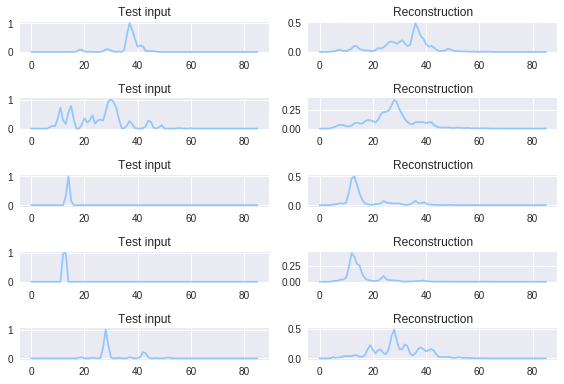

In [15]:
x_sample = pd_bird.train_batch(b_size)[0]
x_reconstruct, _, _ = v.vae(x_sample)
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

In [16]:
x_reconstruct.shape

(100, 86)

(2, 86, 589)


/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


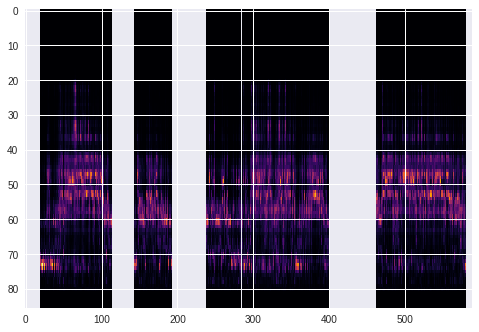

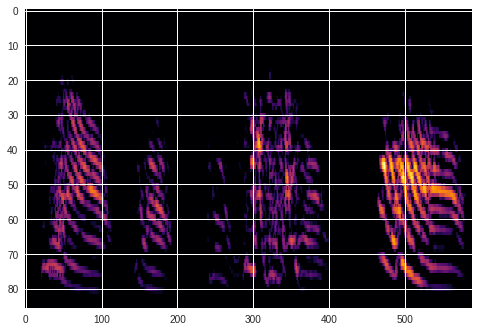

In [17]:
def motiff_reconstruct(n_motiff):
    x_test = pd_bird.test_batch(n_motiff)
    print(x_test.shape)
    x_reconstruct = []
    for i in range(n_motiff):
        
        mot_reconstr, _, _ = v.vae(normalize(x_test[i].T))
        x_reconstruct.append(mot_reconstr.T)
    return np.stack(x_reconstruct, axis=0), x_test

x_r, x_test = motiff_reconstruct(2)
x_r.shape
sample_view = 0
plt.imshow((x_r[sample_view][::-1]), aspect='auto', cmap='inferno')
plt.figure()
plt.imshow(np.log(x_test[sample_view][::-1]), aspect='auto', cmap='inferno')

In [ ]:
plt.plot(x_r[0][:,50])

In [ ]:
plt.plot(normalize(x_test[0])[:,50])

/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


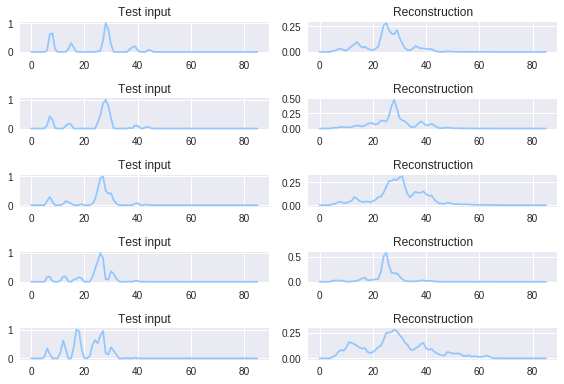

In [18]:
x_sample = normalize(x_test[1][:,150:250].T)
x_reconstruct, _, _ = v.vae(x_sample)
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

In [ ]:
x_test[0].shape

In [ ]:
x_reconstruct[20]

In [ ]:
plt.imshow(np.log(x_test[1][::-1]),  aspect='auto', cmap='inferno')
plt.grid(False)